In [4]:
import torch
from torch import nn
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor()])

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [3]:
# how many samples per batch to load
batch_size = 32

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)

images = images.numpy()
output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [18]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


In [59]:
def train(model, train_loader, lr=0.001, n_epochs=3, noise=False, train_on_gpu=False):
    """
    Train given model based on parameters given
    :param model: autoencoder model
    :param criterion: loss function
    :param optimizer: optimizer  function
    :param train_loader: dataloader
    :param lr: learing rate
    :return: max-pooled feature vector
    """
#     optimizer.param_groups[0]['lr']
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr )
    
    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        for data in train_loader:
            images, labels = data
            if noise:
                images = images + noise_factor * torch.randn(*images.shape)
                images = np.clip(images, 0., 1.)
            
            if train_on_gpu:
                images = images.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        # print avg training statistics 
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
    return model

## Helper function


In [6]:
def save(model, model_name):
    torch.save(model.state_dict(),f"brain\{model_name}.pt")
    
def load_model(model, path):
    return model.load_state_dict(torch.load(path))

## Convolution Auroencoder

In [41]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 5x5 kernels
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)  
        # conv layer (depth from 32 --> 8), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

if train_on_gpu:
    model = model.cuda()

ConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [42]:
train(model, criterion, optimizer, train_loader, train_on_gpu=train_on_gpu)

Epoch: 1 	Training Loss: 4.953319
Epoch: 2 	Training Loss: 4.953319
Epoch: 3 	Training Loss: 4.953319


ConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

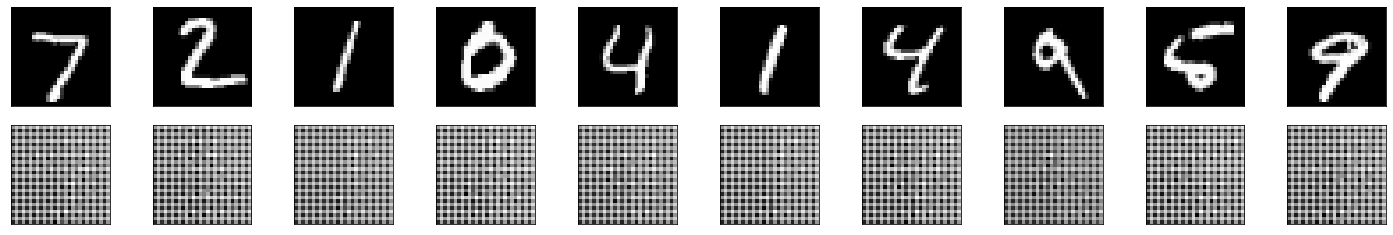

In [39]:
def plot(model, test_loader):
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

#     images_flatten = images.view(images.size(0), -1)
    # get sample outputs
    model.cpu()
    output = model(images)

    images = images.numpy()
    output = output.view(batch_size, 1, 28, 28)
    output = output.detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
plot(model, test_loader)

In [54]:
save(model,"conv-autoencoder")